# Защита персональных данных клиентов

___
**Описание проекта**  

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.
___
**Цель**  

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.
___
**Описание данных:**  

Набор данных находится в файле `/datasets/insurance.csv`.

*Признаки:*

 - пол, возраст и зарплата застрахованного, количество членов его семьи.  

*Целевой признак:*

 - количество страховых выплат клиенту за последние 5 лет.

<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li>
        <li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li>
        <li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li>
        <li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li>
    </ul>
</div>

## Загрузка данных

### Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`. Путь к файлу:

`/datasets/insurance.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats

In [2]:
#Инициализация модели логистической регрессии
from sklearn.linear_model import LinearRegression

#Разделение выборки в заданных пропорциях
from sklearn.model_selection import train_test_split

#Преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#Метрика r2_score
from sklearn.metrics import r2_score

In [3]:
try:
    df = pd.read_csv('/datasets/insurance.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученном датафрейме

**Добавим настройки для удобства отображения данных**

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True)

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 10 строчек датафрейма `df` на экран.**

In [5]:
df.head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,"49,600.00",1,0
1,0,46.00,"38,000.00",1,1
2,0,29.00,"21,000.00",0,0
3,0,21.00,"41,700.00",2,0
4,1,28.00,"26,100.00",0,0
5,1,43.00,"41,000.00",2,1
6,1,39.00,"39,700.00",2,0
7,1,25.00,"38,600.00",4,0
8,1,36.00,"49,700.00",1,0
9,1,32.00,"51,700.00",1,0


**Посмотрим на размер данных (количество строк, колонок).**

In [6]:
print(f'\nКоличество строк: {df.shape[0]}\nКоличество колонок: {df.shape[1]}\n')


Количество строк: 5000
Количество колонок: 5



**Для удобства, сразу приведем обозначения признаков на латиницу и к "змеиному" регистру.**

In [7]:
df = df.rename(columns={
    'Пол': 'gender',
    'Возраст': 'age',
    'Зарплата': 'salary',
    'Члены семьи': 'family_members',
    'Страховые выплаты': 'insurance_payments'
})

In [8]:
df.columns

Index(['gender', 'age', 'salary', 'family_members', 'insurance_payments'], dtype='object')

**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [9]:
df.describe(include = "all")

,gender,age,salary,family_members,insurance_payments
count,"5,000.00","5,000.00","5,000.00","5,000.00","5,000.00"
mean,0.50,30.95,"39,916.36",1.19,0.15
std,0.50,8.44,"9,900.08",1.09,0.46
min,0.00,18.00,"5,300.00",0.00,0.00
25%,0.00,24.00,"33,300.00",0.00,0.00
50%,0.00,30.00,"40,200.00",1.00,0.00
75%,1.00,37.00,"46,600.00",2.00,0.00
max,1.00,65.00,"79,000.00",6.00,5.00


*Признаки:*

- `gender` — пол
- `age` — возраст
- `salary` — зарплата
- `family_members` — члены семьи

*Целевой признак:*

- `insurance_payments` — страховые выплаты

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_payments  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


**Выведем количество пропущенных значений для каждой колонки.**

In [11]:
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

,0
gender,0
age,0
salary,0
family_members,0
insurance_payments,0


**Выведем пропущенные значения в процентном соотношении.**

In [12]:
pd.DataFrame(df.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

,0
gender,0.00%
age,0.00%
salary,0.00%
family_members,0.00%
insurance_payments,0.00%


**Проверим дубликаты.**

In [13]:
df.duplicated().sum()

153

**Выявлены следующие проблемы:**

>1. Привести обозначения признаков на латиницу и к "змеиному" регистру;
>2. В признаках `age`, `salary`, тип значений `float64` следует изменить на `int64`;
>3. Избавится от дубликатов.

**Изменим тип значений `float64` в признаке `age` на `int64`.**

In [14]:
df['age'] = df['age'].astype('int64')

**Изменим тип значений `float64` в признаке `salary` на `int64`.**

In [15]:
df['salary'] = df['salary'].astype('int64')

**Удалим дубликаты.**

In [16]:
df = df.drop_duplicates()

**Посмотрим на распределения числовых признаков `age`, `salary`, `family_members`, `insurance_payments`.**

In [17]:
def plots_numerics(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for index in range(len(x)):
        
        plot = sns.histplot(data[x[index]],
                            color='purple',
                            stat='density',
                            ax=axes[0, index])
        sns.kdeplot(data[x[index]],
                    color='yellow',
                    alpha=0.5,
                    linewidth=3.5,
                    ax=axes[0, index])
        plot.axvline(data[x[index]].mean(), label='mean', c='k', ls='-', lw=2.5)
        plot.axvline(data[x[index]].median(), label='median', c='orange', ls='--', lw=2.5)
        axes[0, index].set(xlabel=xlabel)
        axes[0, index].set(ylabel=ylabel)
        
        sns.boxplot(data=data, x=x[index], color='yellow', ax=axes[1, index])
        sns.stripplot(data=data, x=x[index], color='purple', jitter=0.4, size=1.3, alpha=0.5, ax=axes[1, index])
        axes[1, index].set(xlabel=xlabel)
        axes[1, index].set(ylabel=ylabel)
        
        sns.violinplot(data=data, x=x[index],color='yellow', ax=axes[2, index])
        axes[2, index].set(xlabel=xlabel)
        axes[2, index].set(ylabel=ylabel)

        axes[0, index].set_title(title[x[index]], fontsize=18, pad=15)
    
    fig.suptitle(suptitle, fontsize=22)
    plt.show()

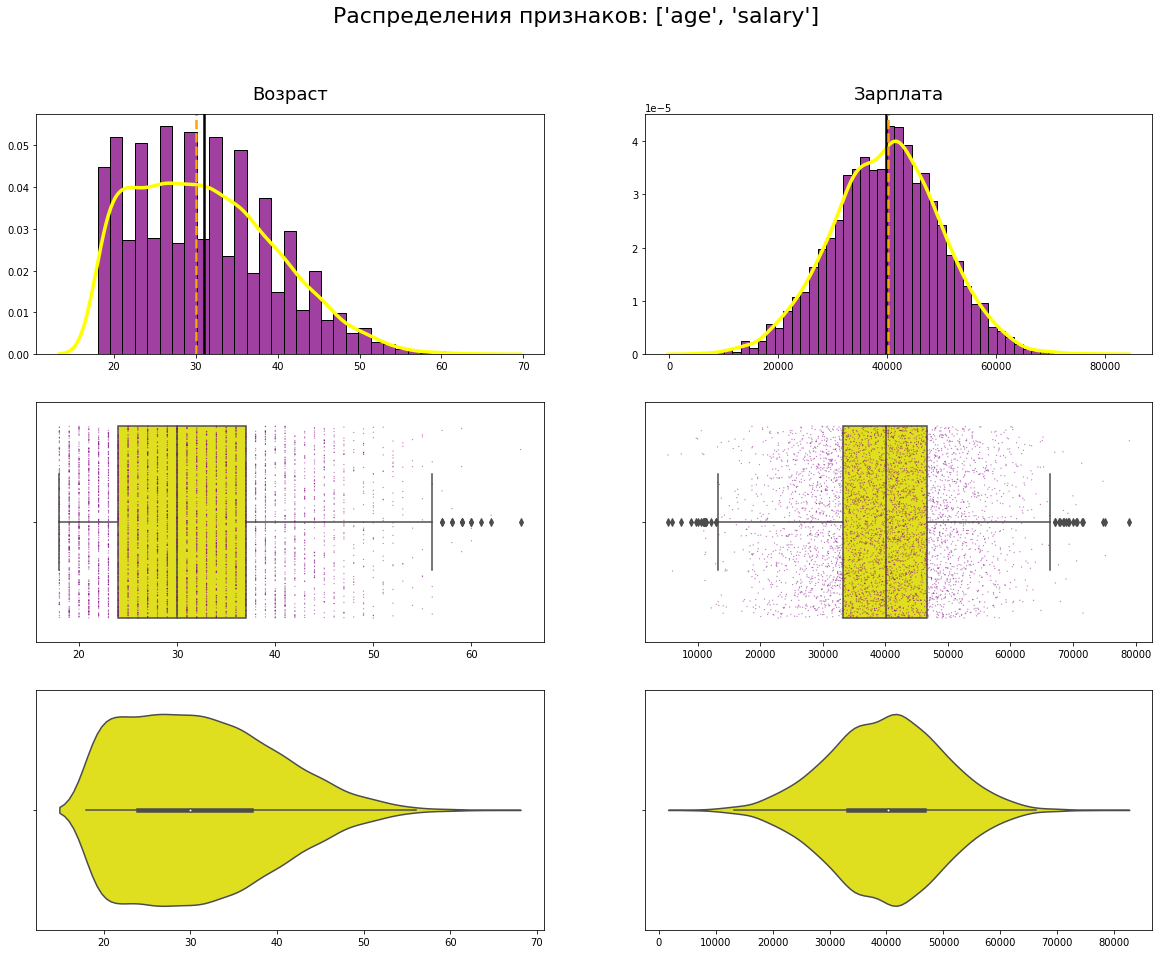

In [18]:
numerical = ['age', 'salary']

plots_numerics(data=df,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'age': 'Возраст',
                      'salary': 'Зарплата'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(20, 15))

**Посчитаем процент выбросов в признаке `age` методом "z оценки".**

In [19]:
z = np.abs(stats.zscore(df['age']))

In [20]:
outliners = df['age'].iloc[np.where(z > 3)].count() / df['age'].shape[0]
print(f'Процент выбросов равен: {outliners:.2%}')

Процент выбросов равен: 0.25%


**Посчитаем процент выбросов в признаке `salary` методом "z оценки".**

In [21]:
z = np.abs(stats.zscore(df['salary']))

In [22]:
outliners = df['salary'].iloc[np.where(z > 3)].count() / df['salary'].shape[0]
print(f'Процент выбросов равен: {outliners:.2%}')

Процент выбросов равен: 0.27%


**Промежуточный вывод:**  
> На графике возраста видим, что клиентами являются совершеннолетние от 18 лет. Данные на обоих графиках распределены нормально. Количество выбросов меньше одного процента.

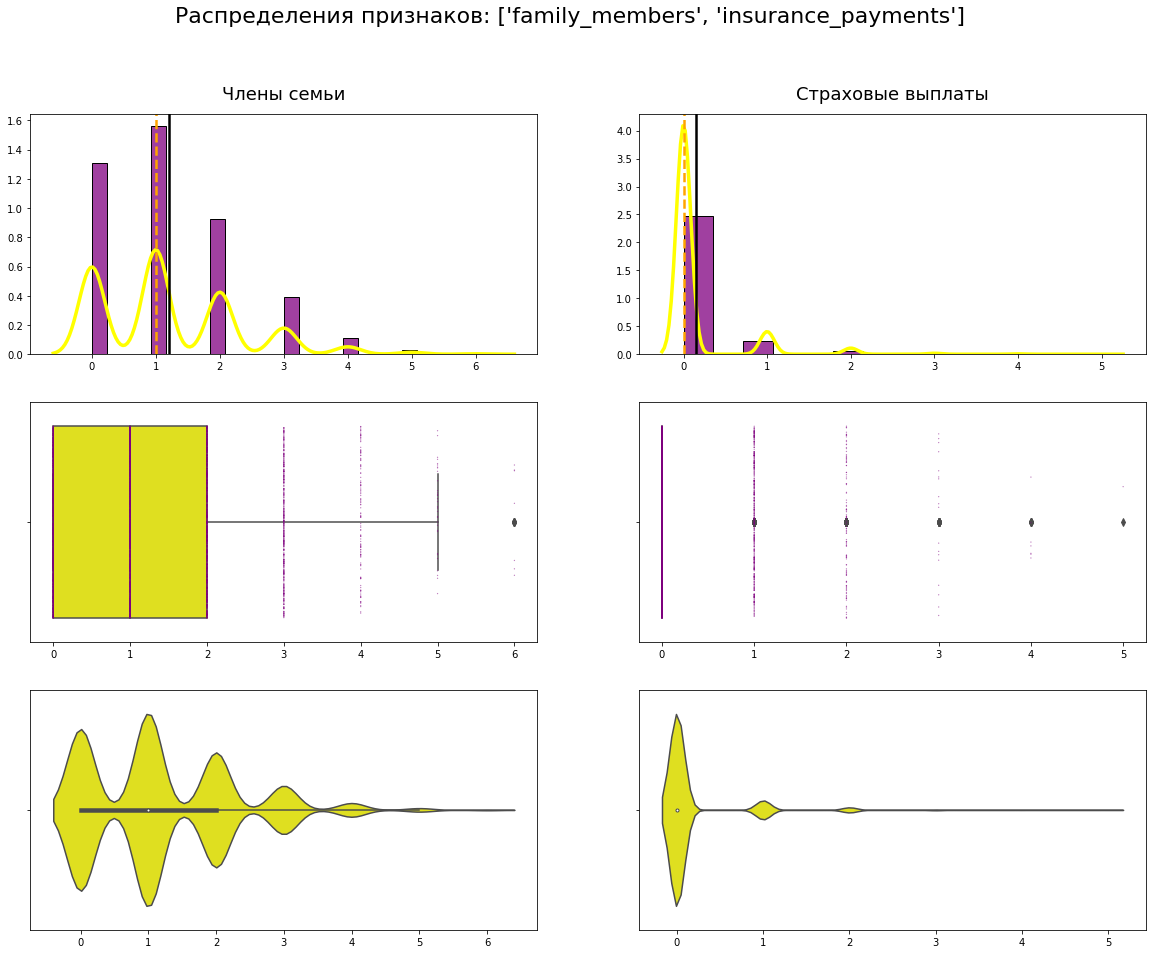

In [23]:
numerical = ['family_members', 'insurance_payments']

plots_numerics(data=df,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'family_members': 'Члены семьи',
                      'insurance_payments': 'Страховые выплаты'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(20, 15))

**Посчитаем процент выбросов в признаке `family_members` методом "z оценки".**

In [24]:
z = np.abs(stats.zscore(df['family_members']))

In [25]:
outliners = df['family_members'].iloc[np.where(z > 3)].count() / df['family_members'].shape[0]
print(f'Процент выбросов равен: {outliners:.2%}')

Процент выбросов равен: 0.80%


**Посчитаем процент выбросов в признаке `insurance_payments` методом "z оценки".**

In [26]:
z = np.abs(stats.zscore(df['insurance_payments']))

In [27]:
outliners = df['insurance_payments'].iloc[np.where(z > 3)].count() / df['insurance_payments'].shape[0]
print(f'Процент выбросов равен: {outliners:.2%}')

Процент выбросов равен: 2.89%


**Промежуточный вывод:**  
> Данные на обоих графиках распределены нормально. Количество выбросов минимальное.

**Посмотрим на распределение категориального признака `gender`.**

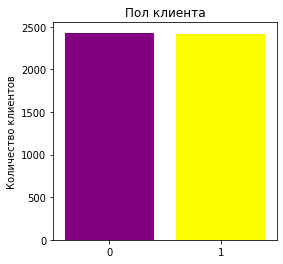

In [28]:
plt.figure(figsize=(4, 4))
palette = {0: 'purple', 1: 'yellow'}
sns.countplot(data=df, x='gender', palette=palette, saturation=1)
plt.xlabel(None)
plt.ylabel('Количество клиентов')
plt.title('Пол клиента')
plt.show()

**Промежуточный вывод:**  
> В текущей выборке пол клиента распределен 50/50.

**Матрица корреляций:**

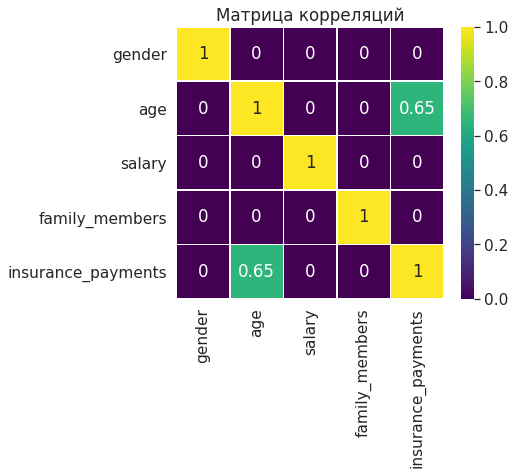

In [29]:
plt.figure(figsize=(6, 5))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='viridis')

plt.title('Матрица корреляций')
plt.show()

**Видим `сильную положительную корреляцию` признаков `age` и `insurance_payments`.**  

**Выводы изучения графиков:**

> Данные графиков распределены нормально. Дополнительных действий с данными, на текущий момент не требуется.

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ: Если умножить признаки на обратимую матрицу, качество линейной регрессии не изменяется.**

**Обоснование:**  



Представим искомую матрицу $X'$ признаков как произведение исходной матрицы $X$ и обратимой матрицы $P$:

$
X' = X\cdot P
$

Подставим новое значение $X'$ в формулу обучения:

$
w' = ((X\cdot P)^T \cdot (X\cdot P))^{-1}\cdot (X\cdot P)^T\cdot Y 
$

Раскроем скобки:

$
w' = ((X\cdot P)^T\cdot X\cdot P)^{-1}\cdot (X\cdot P)^T\cdot y = (P^T\cdot (X^T\cdot X)\cdot P)^{-1}\cdot P^T\cdot X^T\cdot y = P^{-1}\cdot (X^T\cdot X)^{-1}\cdot ((P^T)^{-1}\cdot P^T)\cdot X^T\cdot y
$

Матрица $P$ по условию обратима, следовательно, произведение $(P^T)^{-1}\cdot P^T$ равно единичной матрице $E$:

$
w' = P^{-1}\cdot (X^T\cdot X)^{-1}\cdot ((P^T)^{-1}\cdot P^T)\cdot X^T\cdot y = P^{-1}\cdot (X^T\cdot X)^{-1}\cdot X^T\cdot y
$

Часть полученного выражения совпадает с формулой обучения:

$
w' = P^{-1}\cdot (X^T\cdot X)^{-1}\cdot X^T\cdot y
$

Следовательно:

$
w' = P^{-1}\cdot w
$

Подставим полученное значение весов $w'$ в формулу предсказаний линейной регрессии $a = X\cdot w$:

$
a' = X'\cdot w' = X\cdot P\cdot P^{-1}\cdot w
$

Так как матрица $P$ по условию обратима, то произведение $P\cdot P^{-1}$ равно $E$:

$
a' = X\cdot P\cdot P^{-1}\cdot w = X\cdot E\cdot w = X\cdot w = a
$

Таким образом, предсказания $a'$ для матрицы признаков, умноженной на обратимую матрицу $P$, равны предсказаниям $a$, то есть качество линейной регрессии при умножении признаков на обратимую матрицу не меняется. Т.к., изменяются веса для новых признаков, модель необходимо переобучать на новых признаках.

Параметры линейной регрессии в задачах $w$ и $w'$ связаны следующим образом:

$
w' = P^{-1}\cdot w
$

**Практическое обоснование:**

**Разделим данные на `признаки` и `целевой признак`:**  
* `X` — «признаки»;
* `y` — «целевой признак».

In [30]:
X = df.drop(['insurance_payments'], axis=1)
print(X.shape)

(4847, 4)


In [31]:
y = df['insurance_payments']
print(y.shape)

(4847,)


**Разделим полученные данные в переменных `X`, `y` на `обучающую` и `тестовую` выборки в пропорции `80`:`20`.**

**Данные запишем в новые переменные:**  

`X_train` - `80%`  
`X_test` - `20%`  
`y_train` - `80%`  
`y_test` - `20%`  

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

**Посмотрим на полученные данные.**

In [33]:
print(X_train.shape, X_test.shape)

(3877, 4) (970, 4)


In [34]:
print(y_train.shape, y_test.shape)

(3877,) (970,)


**Для `линейных моделей ML обучения` преобразуем масштаб количественных признаков `age`, `salary`, `family_members` методом стандартизации `StandardScaler()`.**  
**Данные запишем в новые переменные `X_train_scaled` и `X_test_scaled`.**

In [35]:
X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()

In [36]:
features = ['age', 'salary', 'family_members']

In [37]:
scaler = StandardScaler()

In [38]:
scaler.fit(X_train[features])

StandardScaler()

In [39]:
X_train_scaled[features] = scaler.transform(X_train_scaled[features])

In [40]:
X_test_scaled[features] = scaler.transform(X_test_scaled[features])

In [41]:
X_train_scaled.head(3)

,gender,age,salary,family_members
433,1,-0.13,0.53,1.62
4206,1,-0.37,0.52,-1.09
290,1,-1.08,-1.18,-1.09


In [42]:
X_test_scaled.head(3)

,gender,age,salary,family_members
3991,0,-1.43,-0.60,-1.09
1706,0,-0.25,0.82,1.62
1052,0,-0.25,0.03,-1.09


In [43]:
print(X_train_scaled.shape, X_test_scaled.shape)

(3877, 4) (970, 4)


**Создадим класс модели линейной регресии `self_LinearRegression`**

In [44]:
class self_LinearRegression:
    def fit(self, X_train, y_train):
        X = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
        y = y_train
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        print(f'Веса при признаках: {self.w}')
        print(f'Свободный вес: {self.w0}')

    def predict(self, X_test):
        return X_test.dot(self.w) + self.w0

**Обучим класс `self_LinearRegression` на подготовленных данных, получим метрику `r2_score` и `веса` обученной модели.**

In [45]:
model = self_LinearRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
print(f'r2_score: {r2_score(y_test, predictions)}')

Веса при признаках: [ 0.00206417  0.30251068  0.0026045  -0.01684114]
Свободный вес: 0.15166196575329802
r2_score: 0.4392664194820831


**Проделаем предыдущий шаг для модели `LinearRegression` из библиотеки `scikit-learn`**

In [46]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
print(f'Веса при признаках: {model.coef_}')
print(f'Свободный вес: {model.intercept_}')
print(f'r2_score: {r2_score(y_test, predictions)}')

Веса при признаках: [ 0.00206417  0.30251068  0.0026045  -0.01684114]
Свободный вес: 0.15166196575329804
r2_score: 0.4392664194820831


**Видим, что наша модель `self_LinearRegression` работает так же, как и модель `LinearRegression` из библиотеки `scikit-learn`**

**Умножим наши признаки `X_train_scaled` и `X_test_scaled` на обратимую матрицу.**

**Создадим случайную квадратную матрицу, размером по количеству столбцов `X_train_scaled`**

In [47]:
random_matrix = np.random.normal(0, 1, size=(X_train_scaled.shape[1], X_train_scaled.shape[1]))

In [48]:
print(random_matrix)

[[ 1.88744178  1.52164746  0.92352886  0.30521715]
 [-0.34430641 -0.38415538 -0.73734793 -0.36629561]
 [ 0.1908242   0.2981351   0.32811025 -0.83234895]
 [ 0.23805075  0.90754304  0.62115711 -0.26253882]]


**Проверим полученную `random_matrix` матрицу на обратимость.**

In [49]:
np.linalg.det(random_matrix) != 0

True

**Умножим наши признаки на обратимую матрицу `random_matrix`.**

In [50]:
encoded_X_train_scaled = X_train_scaled.dot(random_matrix)

In [51]:
print(encoded_X_train_scaled)

        0    1    2     3
433  2.42 3.20 2.20 -0.51
4206 1.85 0.83 0.69  0.29
290  1.77 0.59 0.65  1.97
2644 1.77 1.27 0.65  0.26
4251 0.43 0.82 1.12  1.56
...   ...  ...  ...   ...
4563 2.60 2.37 2.27 -0.95
467  1.80 1.19 0.82  1.68
3166 2.23 2.87 1.91  0.76
3880 1.80 1.68 1.01  2.37
865  2.65 2.87 2.59  0.22

[3877 rows x 4 columns]


In [52]:
encoded_X_test_scaled = X_test_scaled.dot(random_matrix)

In [53]:
print(encoded_X_test_scaled)

         0     1     2     3
3991  0.12 -0.62  0.18  1.31
1706  0.63  1.81  1.46 -1.01
1052 -0.17 -0.88 -0.48  0.36
4959  0.02  1.59  0.36 -0.73
1554  0.13  0.10  0.19 -0.68
...    ...   ...   ...   ...
2613  1.75  0.57  0.59  1.87
1523  1.55  0.89  0.30  1.67
1136 -0.36 -0.59 -0.72  0.57
180   0.74  0.83  1.44 -0.69
1226 -0.23 -0.46 -0.43  0.89

[970 rows x 4 columns]


**Обучим нашу модель на новых признаках `encoded_X_train_scaled` и `encoded_X_test_scaled`. Cверим результаты.**

In [54]:
model = self_LinearRegression()
model.fit(encoded_X_train_scaled, y_train)
predictions = model.predict(encoded_X_test_scaled)
print(f'r2_score: {r2_score(y_test, predictions)}')

Веса при признаках: [ 0.02602436  0.31545936 -0.53880286 -0.09656485]
Свободный вес: 0.15166196575329738
r2_score: 0.43926641948208345


**Вывод:**  
> Качество линейной регресии на новых признаках `encoded_X_scaled` не изменилось.

## Алгоритм преобразования

**Алгоритм**

* 1. Функция на вход получает матрицу признаков (X);
* 2. Определяется количество признаков (X.shape[1]) в матрице признаков;
* 3. В цикле while:
  * 3.1 Генерируется случаяная (random_matrix) квадратная матрица (np.random.randint), исходя из количества признаков в матрице признаков;
  * 3.2 Детерминантом не равным нулю (np.linalg.det(random_matrix) != 0), проверяется, является ли сгенерированная матрица обратимой;
* 4. Матрица признаков (X), умножается на случаяную квадратную матрицу (random_matrix);
* 5. Функция на выходе возвращает преобразованную матрицу признаков (encoded_X).

**Обоснование**

Предсказания вычисляются по формуле:

$
a = X\cdot w
$

После умножения матрицы признаков $X$ на обратимую матрицу $M$, формула будет выглядеть:

$
a^{1} = X\cdot M\cdot w^{1}
$

Подставим вычисленное значение весов $w^{1} = M^{-1}\cdot w$:

$
a^{1} = X\cdot M\cdot M^{-1}\cdot w
$

$M\cdot M^{-1}$ равно единичной матрице $E$, следовательно $M\cdot M^{-1}$ можно сократить:

$
a^{1} = X\cdot w = a
$

**Следовательно, предсказания исходной матрицы и преобразованной - равны.**

## Проверка алгоритма

### Реализация алгоритма

**Алгоритм преобразования признаков реализуем в функции `encode`.**

In [56]:
def encode(X_train, X_test):
    
    size = X_train.shape[1]

    while True:
        random_matrix = np.random.randint(100, size=(size, size))

        if np.linalg.det(random_matrix) != 0:
            break
    
    encoded_X_train = X_train.dot(random_matrix)
    encoded_X_test = X_test.dot(random_matrix)
    
    return encoded_X_train, encoded_X_test

In [57]:
encoded_X_train_scaled, encoded_X_test_scaled = encode(X_train_scaled, X_test_scaled)

### Сравнение качества моделей до и после преобразования

**До преобразования:**

In [58]:
model = self_LinearRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
print(f'r2_score: {r2_score(y_test, predictions)}')

Веса при признаках: [ 0.00206417  0.30251068  0.0026045  -0.01684114]
Свободный вес: 0.15166196575329802
r2_score: 0.4392664194820831


**После преобразования:**

In [59]:
model = self_LinearRegression()
model.fit(encoded_X_train_scaled, y_train)
predictions = model.predict(encoded_X_test_scaled)
print(f'r2_score: {r2_score(y_test, predictions)}')

Веса при признаках: [ 0.00636962 -0.00728743  0.00868925 -0.00308943]
Свободный вес: 0.1516619657532982
r2_score: 0.43926641948208334


**Вывод:**  
> Качество `метрики R2` на новых признаках `encoded_X_train_scaled` и `encoded_X_test_scaled` не изменилось.

## Общий вывод

**В ходе проекта было проделано:**

* Данные загружены и изучены;
* Выяснено, что при умножении матрицы на обратимую матрицу, качество линейной регрессии не меняется;
* Описан алгоритм преобразования матрицы;
* Алгоритм преобразования признаков реализован и проверен;

**Умножив признаки на обратимую матрицу, качество линейной регрессии не меняется.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования